<a href="https://colab.research.google.com/github/ddhira123/Bird-Identification/blob/master/Skripsi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
working_dir = '/content/drive/MyDrive/Skripsi/[NEW TOPIC] Wildlife Identification/Code/'

In [ ]:
!git clone https://github.com/ddhira123/Bird-Identification.git

fatal: destination path 'Bird-Identification' already exists and is not an empty directory.


In [ ]:
working_dir = 'Bird-Identification'

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

## Import Dataset

In [ ]:
dataset_dir = working_dir + '/data'

train_dir = dataset_dir + '/train'
test_dir = dataset_dir + '/test'


In [ ]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1/255.,
    width_shift_range=0.2, 
    height_shift_range=0.2
)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [ ]:
IMG_SIZE = (224, 224)
train_gen = train_datagen.flow_from_directory(train_dir,
                                              batch_size=64,
                                              shuffle=True,
                                              target_size=IMG_SIZE)

test_gen = test_datagen.flow_from_directory(test_dir,
                                            target_size=IMG_SIZE)

Found 320 images belonging to 10 classes.
Found 80 images belonging to 10 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False

In [ ]:
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(16, activation='relu'),
                             tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                170       
Total params: 2,278,650
Trainable params: 20,666
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
callback_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback_acc = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
history = model.fit(train_gen, validation_data=test_gen, epochs=50, callbacks=[callback_acc, callback_loss])

Epoch 1/50
5/5 [==============================] - 6s 914ms/step - loss: 2.4716 - accuracy: 0.1625 - val_loss: 2.2518 - val_accuracy: 0.2125
Epoch 2/50
5/5 [==============================] - 4s 736ms/step - loss: 2.1633 - accuracy: 0.2438 - val_loss: 2.0154 - val_accuracy: 0.3125
Epoch 3/50
5/5 [==============================] - 4s 747ms/step - loss: 1.9284 - accuracy: 0.3219 - val_loss: 1.8428 - val_accuracy: 0.3250
Epoch 4/50
5/5 [==============================] - 4s 736ms/step - loss: 1.7281 - accuracy: 0.4656 - val_loss: 1.6802 - val_accuracy: 0.4125
Epoch 5/50
5/5 [==============================] - 4s 740ms/step - loss: 1.4884 - accuracy: 0.5344 - val_loss: 1.5320 - val_accuracy: 0.4375
Epoch 6/50
5/5 [==============================] - 4s 741ms/step - loss: 1.3954 - accuracy: 0.5750 - val_loss: 1.4058 - val_accuracy: 0.5125
Epoch 7/50
5/5 [==============================] - 4s 734ms/step - loss: 1.3267 - accuracy: 0.5844 - val_loss: 1.2921 - val_accuracy: 0.5625
Epoch 8/50
5/5 [====

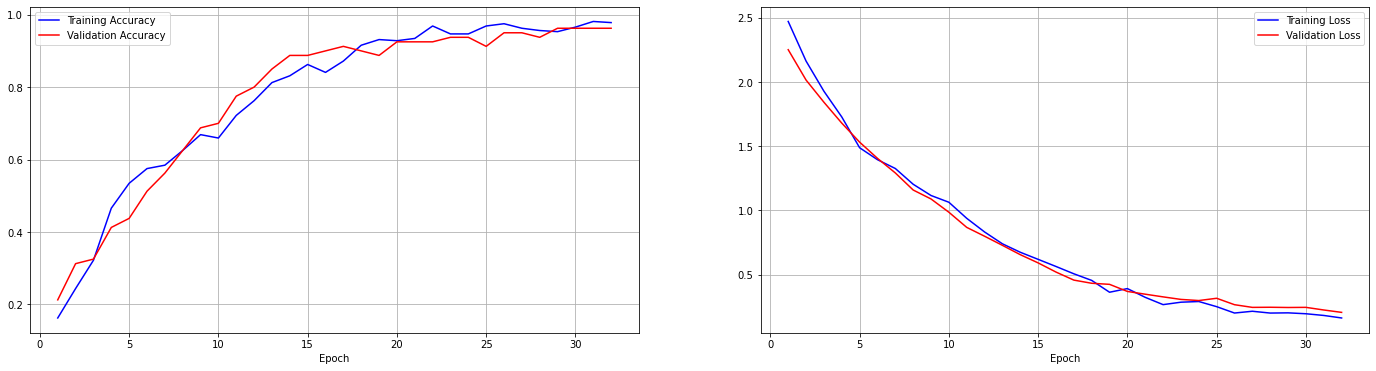

In [ ]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

plot_results(history)

In [ ]:
model.save(working_dir+'/SavedModel.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!cd $working_dir

fatal: not a git repository (or any of the parent directories): .git
